# 0. Readme
- 실행환경 : Colab, 런타임유형 'GPU', python  3.7.12
- 외부데이터 : 사용안함
- 데이터로드 : 구글 드라이브에 업로드 후 마운트하여 로드
- 실행방법 : ipynb 파일 Colab에 업로드 시 동일조건으로 실행가능
- 설명자료 : 코드에 설명포함하여 작성

# 1. Data Load
- 연/월/일/요일 변수 생성
- Noise 제거 및 효율적 학습을 위해 매년 1~3월 데이터만 사용  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import *
import functools
import seaborn as sns
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive, files
drive.mount('/content/drive')


train = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/train.csv', parse_dates=['연월일'])
test = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/test.csv')
submission = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/sample_submission.csv')

train.rename({'연월일':'date', '시간':'hour', '구분':'type', '공급량':'amount'}, axis='columns', inplace=True)

test['date'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['type'] = test['일자|시간|구분'].str.split(' ').str[2]
test['date'] = pd.to_datetime(test['date'])
test.drop('일자|시간|구분', axis=1, inplace=True)

# 연/월/일/요일 변수 생성
for df in [train, test]:
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['weekday'] = df['date'].dt.weekday
  df['type'] = df['type'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'G':5, 'H':6})
  # df.drop('date', axis=1, inplace=True)

# Noise 제거 및 효율적 학습을 위해 매년 1~3월 데이터만 사용
train = train[train['month'] < 4].reset_index(drop=True)
df_chk = train.copy()

Mounted at /content/drive


# 2. EDA

## Data EDA

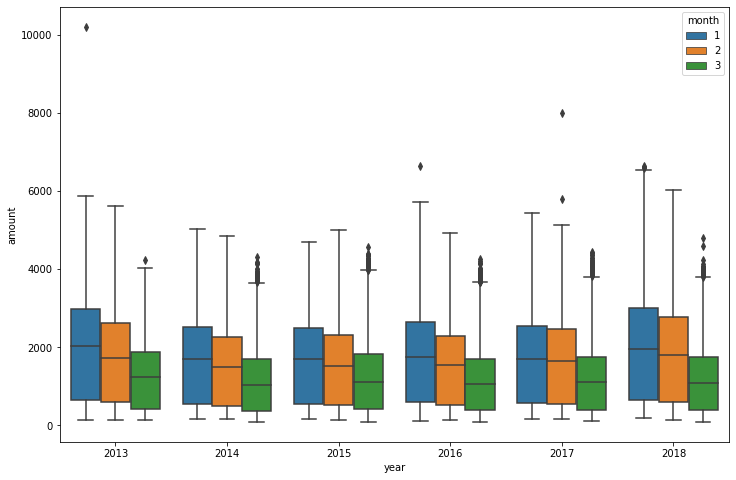

In [2]:
plt.figure(figsize=(12,8))
sns.boxplot(data = train, x = 'year', y = 'amount', hue='month')

In [3]:
print(train['type'].unique())
for x in train['type'].unique():
  print(x,'공급사 데이터 수', len(train[train['type'] == x]))

[0 1 2 3 4 5 6]
0 공급사 데이터 수 12984
1 공급사 데이터 수 12984
2 공급사 데이터 수 12984
3 공급사 데이터 수 12984
4 공급사 데이터 수 12984
5 공급사 데이터 수 12984
6 공급사 데이터 수 12984


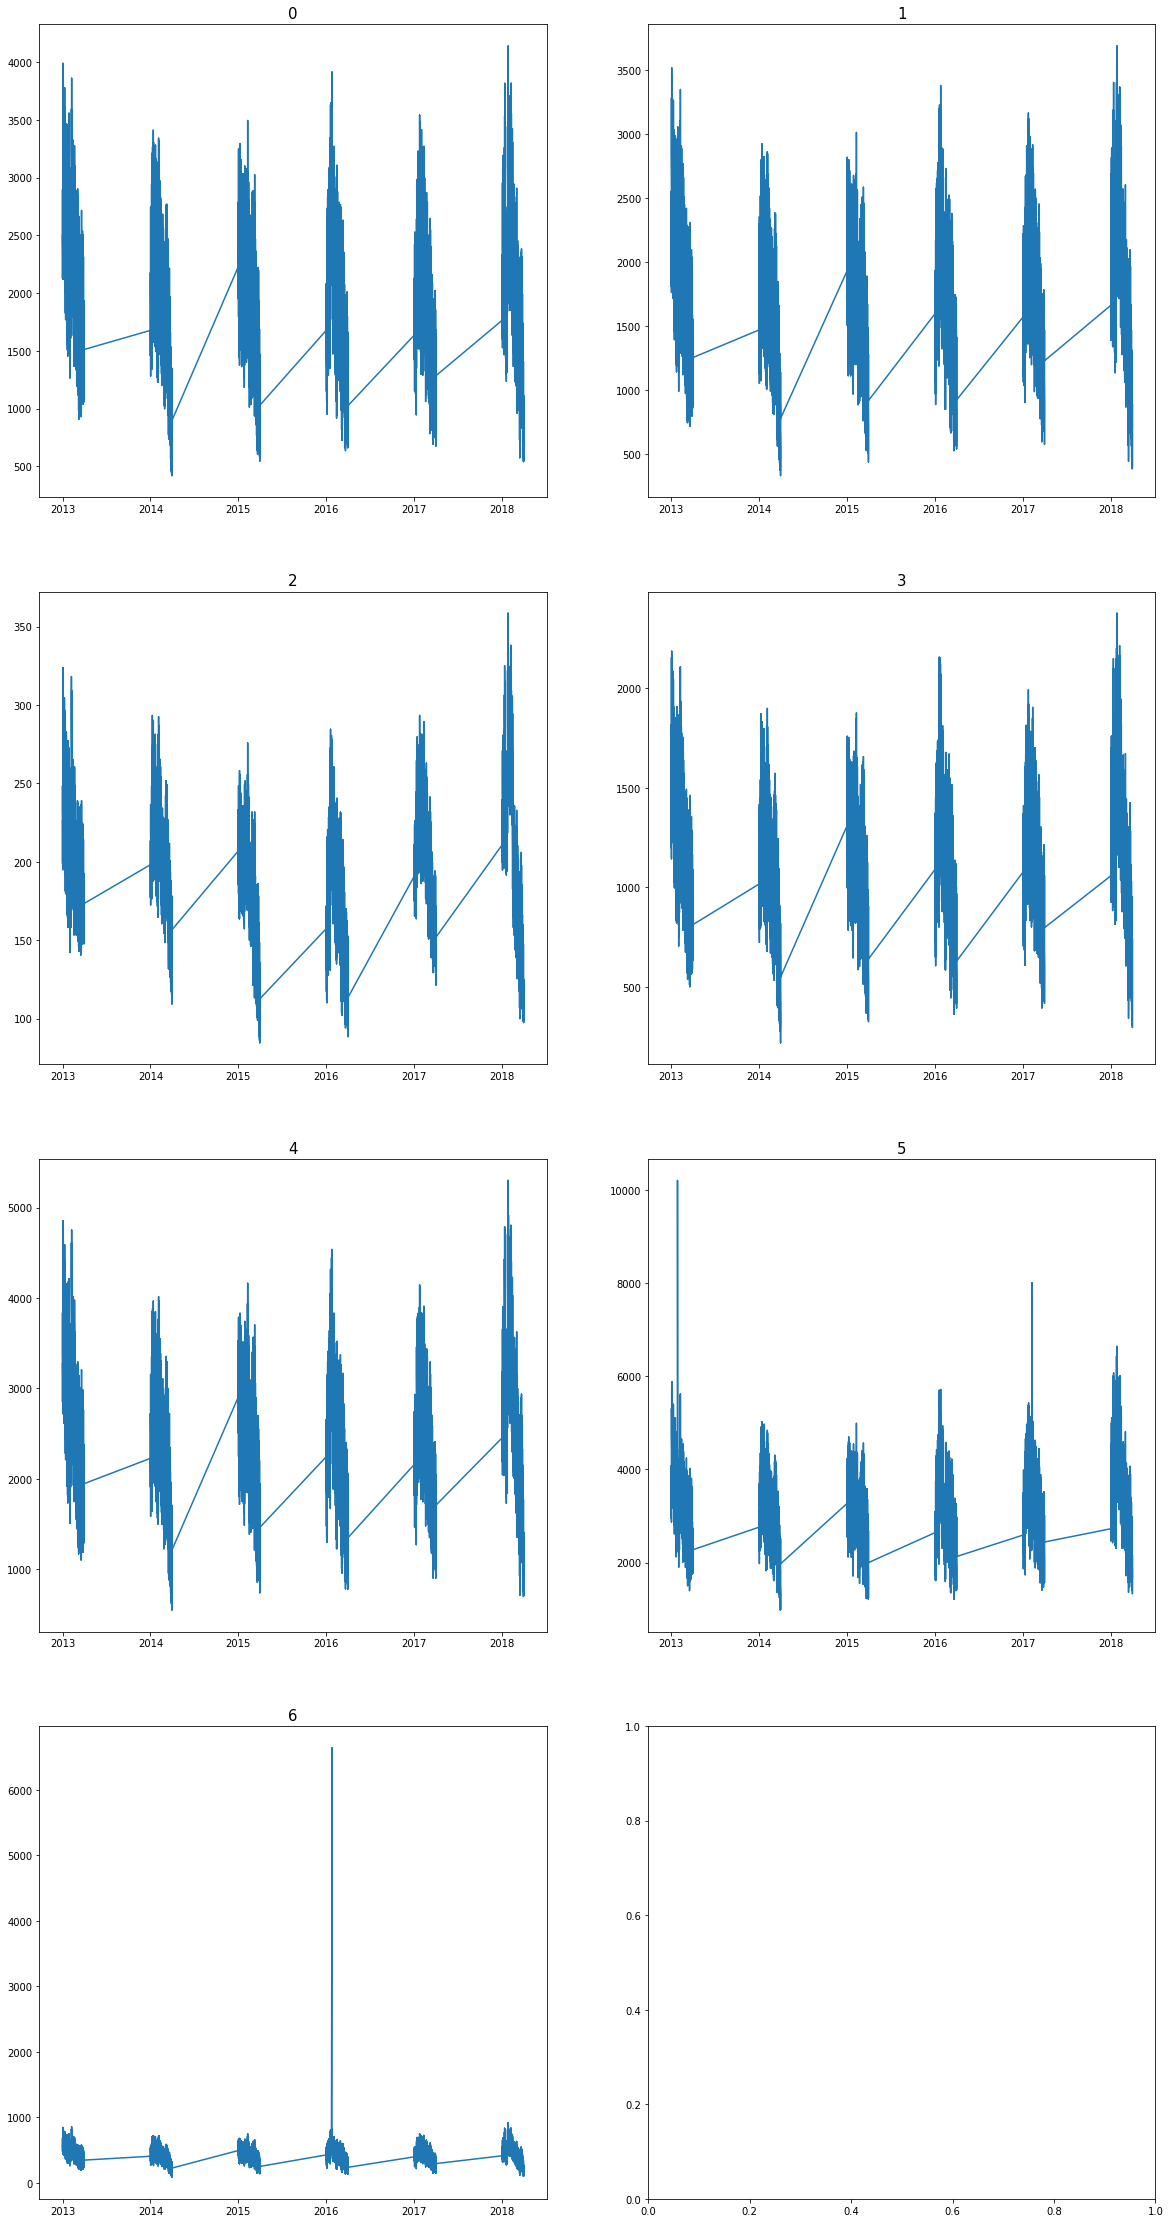

In [4]:
# 공급사별 일자별 공급량 확인

fig, axes = plt.subplots(4,2, figsize = (20,40))
ax = axes.flatten()

num = 0
for x in train['type'].unique():
  train_ = train[train['type'] == x]
  ax[num].plot(train_['date'], train_['amount'])
  ax[num].set_title(x).set_fontsize(15)
  num += 1

- 대회 설명회에서 이상치는 실제 이상치일수 있고, 아닐수도 있다고 언급함
- 이상치에 대한 과도한 조정은 도메인 정보가 손실될 우려가 있음
- 따라서 IQR등에 의한 일괄적인 이상치 처리는 적절하지 않다고 판단
- EDA 결과를 바탕으로 학습에 방해가 될 구간에 한하여 최소한의 이상치 처리가 적절하다고 판단됨

- 예) G, H 공급사의 공급량 6,500을 초과하는 구간

## Base model prediction result EDA
- 기본모델의 예측값과 train 데이터의 실제 공급량과 차이를 비교

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[35]	valid_0's mape: 0.0192329
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[35]	valid_0's mape: 0.0213138
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0198283
[200]	valid_0's mape: 0.0197985
[300]	valid_0's mape: 0.0197988
Early stopping, best iteration is:
[256]	valid_0's mape: 0.0197957
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0220963
[200]	valid_0's mape: 0.0220525
[300]	valid_0's mape: 0.0220484
Early stopping, best iteration is:
[311]	valid_0's mape: 0.0220476
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0171008
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0247377
[200]	valid_0's mape: 0.0247249
Early stopping, best iteration is:
[204]

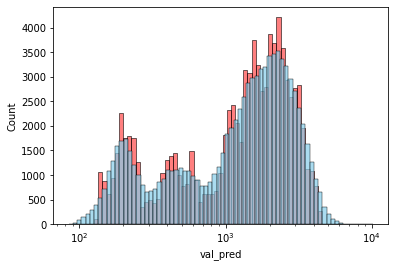

In [5]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold


def nmae(y_true, y_pred):
    y_pred = np.expm1(y_pred)
    score = np.mean((np.abs(y_true-y_pred))/y_true)    
    return score

vars = ['hour',	'type', 'month',	'weekday']

X = train[vars]
y = train['amount']
log_y = np.log1p(y)

X_test = test[vars]

categorical_features = ['hour','type','weekday', 'month']

for i in enumerate (categorical_features) : 
    ca = i[1] 
    X[ca] = X[ca].astype('category') 
    X_test[ca] = X_test[ca].astype('category')


params = {
    "objective": "regression", 
    "boosting": "gbdt",
    "metric": "mape",
    "seed":2021,
}


n_fold = 6
kf = KFold(n_splits=n_fold, random_state=None)


pred_val = np.zeros(int(len(X)/n_fold))
lgb_pred = np.zeros(len(test))

df_val_pred = pd.DataFrame()

for train_index, val_index in kf.split(X):

    train_features = X.loc[train_index]
    train_target = log_y.loc[train_index]
    
    val_features = X.loc[val_index]
    val_target = log_y.loc[val_index]
    
    d_training = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical_features, free_raw_data=False)
    d_val = lgb.Dataset(val_features, label=val_target, categorical_feature=categorical_features, free_raw_data=False)

    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets= d_val, verbose_eval=100, early_stopping_rounds=50)
    
    val_pred = model.predict(val_features)
    df_val = pd.DataFrame({'val_pred':val_pred}, index = val_index) 
    df_val_pred = df_val_pred.append(df_val)
    
    test_pred = np.expm1(model.predict(X_test))
    lgb_pred += test_pred / n_fold



sns.histplot(np.expm1(df_val_pred['val_pred']), color = 'red', alpha = 0.5,log_scale=True)
sns.histplot(df_chk['amount'], color = 'skyblue', alpha = 0.7,log_scale=True)

print('\nval_nmae', nmae(df_chk['amount'].values, df_val_pred['val_pred'].values))

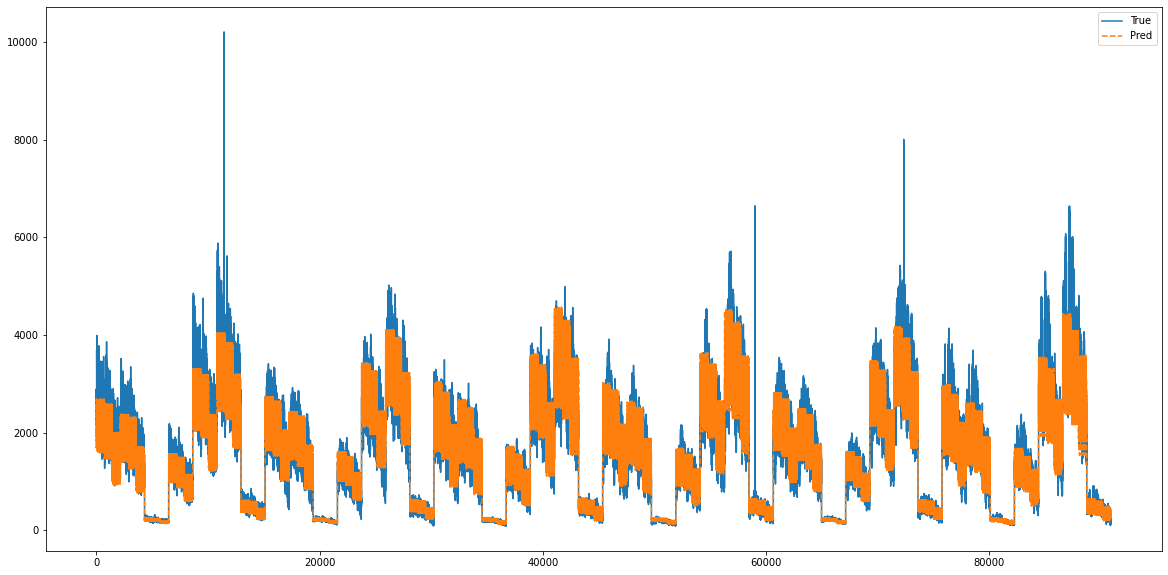

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(df_chk.index, df_chk['amount'], linestyle = "-", label = "True")
plt.plot(df_chk.index, np.expm1(df_val_pred['val_pred']), linestyle = "--", label = "Pred")

plt.legend()

- 공급량 3,000 이상 또는 2,000 이하 구간에서 예측력이 떨어짐을 확인
- 평가지표인 NMAE에서는 공급량이 적은 구간의 예측력이 중요함
- 예1) true 6000, pred 4000,  nmae = abs(6000-4000)/6000 = 0.33 
- 예2) true 500, pred 1500,  nmae = abs(500-1500)/500 = 2

In [7]:
# train 데이터의 예측값과 실제값의 NMAE 확인을 위한 데이터프레임 생성
pred_chk = df_chk[['year', 'month', 'day', 'hour', 'type', 'amount']].join(np.expm1(df_val_pred['val_pred']))
pred_chk['nmae'] = np.abs(pred_chk['amount'] - pred_chk['val_pred'])/pred_chk['amount']
pred_chk['nmae'].describe()

count    90888.000000
mean         0.144150
std          0.123827
min          0.000003
25%          0.054528
50%          0.115763
75%          0.201343
max          1.788356
Name: nmae, dtype: float64

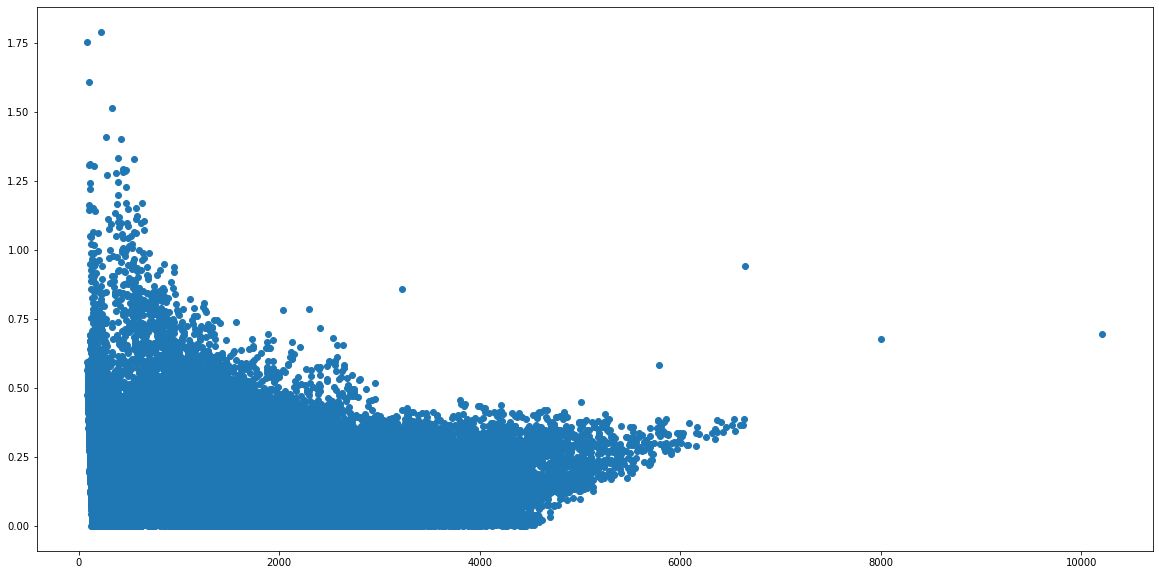

In [8]:
# 공급량과 NMAE의 산점도 분석
plt.scatter(pred_chk['amount'], pred_chk['nmae'])
plt.show()

- 공급량이 적을때 NMAE가 높은 경우가 많음

In [9]:
# NMAE의 아웃라이어 확인
print('NMAE outlier :', (np.percentile(pred_chk['nmae'], 75) - np.percentile(pred_chk['nmae'], 25))*1.5 + np.percentile(pred_chk['nmae'], 75))

NMAE outlier : 0.4215664934903567


In [10]:
# NMAE가 아웃라이어 이상인 데이터 확인
nmae_chk = pred_chk[pred_chk['nmae']>0.4215]
print('NMAE outlier 수 :', len(nmae_chk))
print('전체 data 수 :', len(pred_chk))
print('NMAE outlier 비율 {:0.2f}%'.format(len(nmae_chk)/len(pred_chk)*100))
print('NMAE outlier의 평균 NMAE {:0.3f}'.format(nmae_chk['nmae'].mean()))

NMAE outlier 수 : 2775
전체 data 수 : 90888
NMAE outlier 비율 3.05%
NMAE outlier의 평균 NMAE 0.570


In [11]:
# NMAE가 높은 순으로 정렬
pd.set_option('display.max_rows', 30)
nmae_chk.sort_values('nmae', ascending=False).head(30)

,year,month,day,hour,type,amount,val_pred,nmae
23738,2014,3,31,3,3,220.036,613.538700,1.788356
30218,2014,3,31,3,6,85.804,236.073044,1.751306
30219,2014,3,31,4,6,96.772,252.407664,1.608272
19418,2014,3,31,3,1,329.813,828.435404,1.511834
23737,2014,3,31,2,3,267.956,645.606722,1.409376
17258,2014,3,31,3,0,420.265,1008.993792,1.400851
19417,2014,3,31,2,1,387.493,903.970612,1.332870
25898,2014,3,31,3,4,549.389,1279.768349,1.329439
30171,2014,3,29,4,6,109.252,252.407664,1.310325
30194,2014,3,30,3,6,102.380,236.073044,1.305851


- train 데이터의 예측값과 실제값의 NMAE 확인결과, 특정 구간에서 NMAE가 매우 높음을 확인
- 예) 3월말, 2~4시

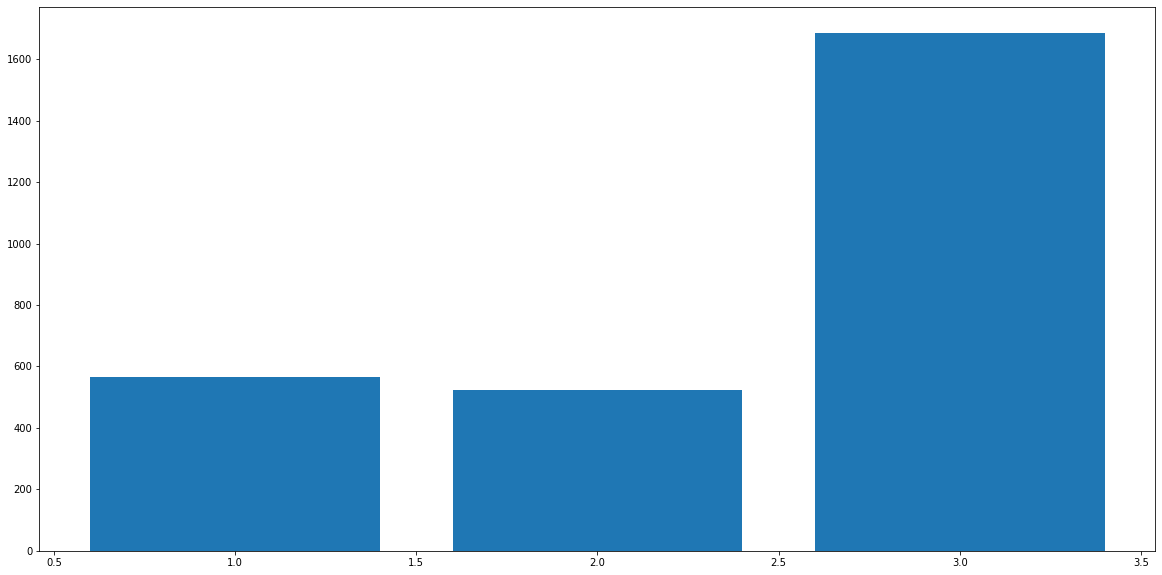

3    1685
1     566
2     524
Name: month, dtype: int64


In [12]:
# NMAE가 아웃라이어 이상인 경우 데이터 확인
plt.bar(nmae_chk['month'].value_counts().index, nmae_chk['month'].value_counts())
plt.show()
print(nmae_chk['month'].value_counts())

- NMAE가 높은 경우는 3월이 대부분임

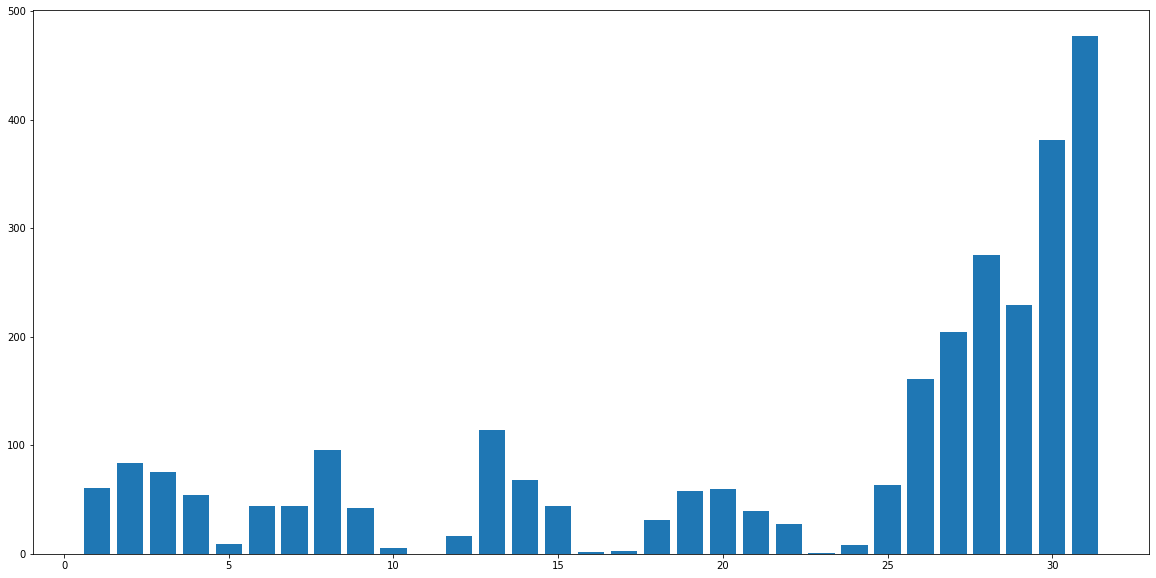

31    477
30    381
28    275
29    229
27    204
26    161
13    114
8      96
Name: day, dtype: int64

In [13]:
# NMAE가 아웃라이어 이상인 경우 데이터 확인
plt.bar(nmae_chk['day'].value_counts().index, nmae_chk['day'].value_counts())
plt.show()
nmae_chk['day'].value_counts()[:8] 

- NMAE이 높은 경우는 29~31일이 가장 많음

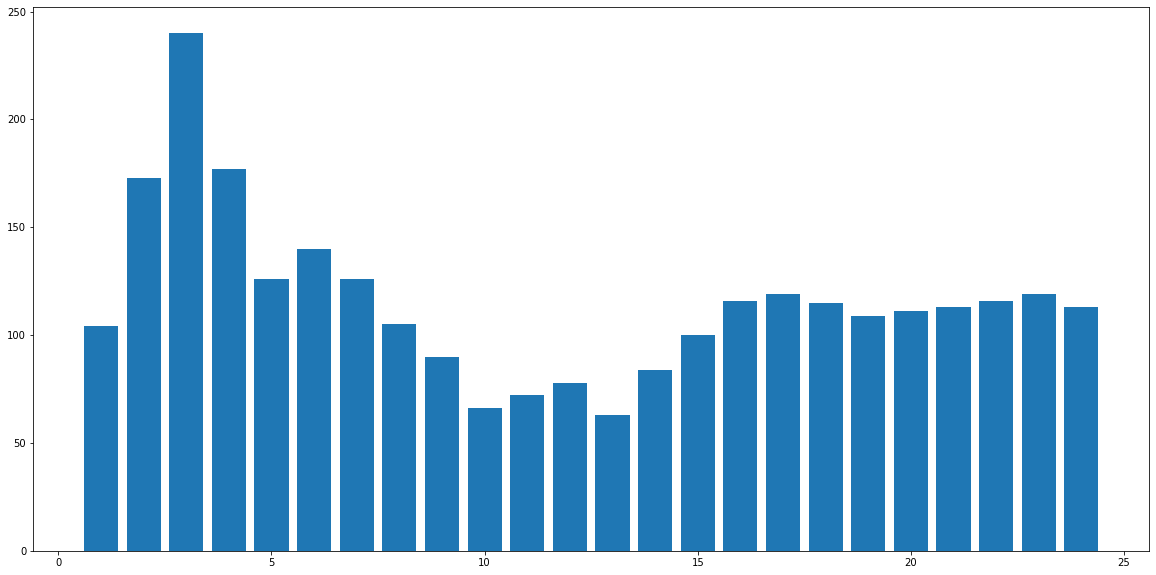

3     240
4     177
2     173
6     140
7     126
5     126
23    119
17    119
Name: hour, dtype: int64

In [14]:
plt.bar(nmae_chk['hour'].value_counts().index, nmae_chk['hour'].value_counts())
plt.show()
nmae_chk['hour'].value_counts()[:8]

- NMAE이 높은 경우는 2~4시가 가장 많음

# Data Preprocessing
- EDA 결과를 반영하여, 공급량 6644 이상인 구간은 이상치로 판단하여 처리
- 공급사별 이상치 분포 특성을 고려하여 이상치 대체방법을 다르게 적용
- 특정구간(3월말, 2~4시)에서 모델 예측력이 떨어지는것을 확인
- 모델 예측력이 떨어지는 특정구간을 피쳐화 하여 예측력 보완

In [15]:
# 2016년 H 공급사 이상치는 +1, -1 일 동시간의 공급량 평균으로 대체
for row in train[(train['type'] == 6) & (train['year'] == 2016) & (train['month'] == 1) & (train['day'] == 24) & (train['hour'] < 4)&(train['amount'] > 800)].index:
  train.loc[row, 'amount'] = (train.loc[(row-24), 'amount'] + train.loc[(row+24), 'amount'])/2

# 공급량 6644이상인 것은 이상치로 판단하고 +1, -1 시간의 공급량 평균으로 대체
for row in train[train['amount'] > 6644].index:
  train.loc[row, 'amount'] = (train.loc[(row-1), 'amount'] + train.loc[(row+1), 'amount'])/2

# 예측력이 떨어지는 기간 피쳐화 (3월말, 2~4시)
for df in [train, test]:
  df['little_gas'] = 0
  df.loc[(df['month'] == 3) & (df['day'] >=29) & (df['hour'] >=2) & (df['hour'] <=4), 'little_gas'] = 1
  df['26~31'] = df['day'].apply(lambda x : 1 if x >= 26 else 0)
  df['2~7'] = df['hour'].apply(lambda x : 1 if x >= 2 and x <= 7 else 0)

df_chk = train.copy()

# Modeling
- LGBM, XGB, Catboost 적용후 3개 모델의 Minimum Ensemble 실시
- 사용하는 변수를 최소화하여 일반화된 모델 구현
- 모델 학습시 대회 평가지표인 'NMAE'를 Custom metric으로 적용
- 하이퍼파라미터를 Optuna로 조정시 과적합되는 경향이 있어 val_nmae 점수와 예측결과의 시각화 결과를 확인하며 수동으로 조정
- fold는 3~24까지 시도후 모델별 최적 fold 적용

## LGBM

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0193109	valid_0's nmae: 0.125071
Early stopping, best iteration is:
[81]	valid_0's mape: 0.0192393	valid_0's nmae: 0.125443
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0194265	valid_0's nmae: 0.141691
Early stopping, best iteration is:
[83]	valid_0's mape: 0.0192993	valid_0's nmae: 0.140726
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0191299	valid_0's nmae: 0.135616
Early stopping, best iteration is:
[97]	valid_0's mape: 0.0191161	valid_0's nmae: 0.1354
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0218566	valid_0's nmae: 0.153344
Early stopping, best iteration is:
[139]	valid_0's mape: 0.0216597	valid_0's nmae: 0.152386
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0167286	valid_0's nmae: 0.118684
Early stopping, best iteration is:
[80]	va

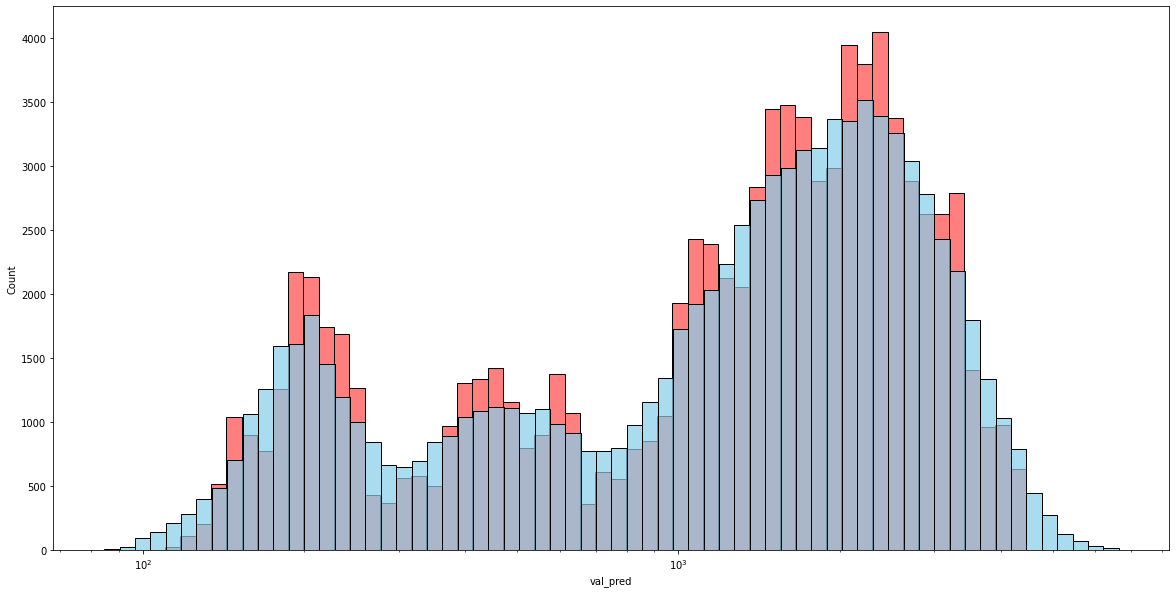

In [16]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold


def nmae(y_true, y_pred):
    y_pred = np.expm1(y_pred)
    score = np.mean((np.abs(y_true-y_pred))/y_true)    
    return score

def feval(y_pred, train_data):
  y_true = train_data.get_label()
  y_pred = np.expm1(y_pred)
  y_true = np.expm1(y_true)
  score = np.mean((np.abs(y_true-y_pred))/y_true)    
  return 'nmae', score, False


vars = ['hour',	'type', 'month',	'weekday', 'little_gas', '26~31','2~7']

X = train[vars]
y = train['amount']
log_y = np.log1p(y)

X_test = test[vars]

categorical_features = ['hour','type','weekday', 'month', 'little_gas', '26~31','2~7']

for i in enumerate (categorical_features) : 
    ca = i[1] 
    X[ca] = X[ca].astype('category') 
    X_test[ca] = X_test[ca].astype('category')


params = {
    "objective": "regression", 
    "boosting": "gbdt",
    "num_leaves": 34, 
    "learning_rate": 0.06, 
    "feature_fraction": 0.85, 
    "reg_lambda": 2, 
    "metric": "mape",
    "seed":2021,
}


n_fold = 6
kf = KFold(n_splits=n_fold, random_state=None)


pred_val = np.zeros(int(len(X)/n_fold))
lgb_pred = np.zeros(len(test))

df_val_pred = pd.DataFrame()

for train_index, val_index in kf.split(X):

    train_features = X.loc[train_index]
    train_target = log_y.loc[train_index]
    
    val_features = X.loc[val_index]
    val_target = log_y.loc[val_index]
    
    d_training = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical_features, free_raw_data=False)
    d_val = lgb.Dataset(val_features, label=val_target, categorical_feature=categorical_features, free_raw_data=False)

    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets= d_val, verbose_eval=100, early_stopping_rounds=50,
                      feval = feval)
    
    val_pred = model.predict(val_features)
    df_val = pd.DataFrame({'val_pred':val_pred}, index = val_index) 
    df_val_pred = df_val_pred.append(df_val)
    
    test_pred = np.expm1(model.predict(X_test))
    lgb_pred += test_pred / n_fold



sns.histplot(np.expm1(df_val_pred['val_pred']), color = 'red', alpha = 0.5,log_scale=True)
sns.histplot(df_chk['amount'], color = 'skyblue', alpha = 0.7,log_scale=True)

print('\nval_nmae', nmae(df_chk['amount'].values, df_val_pred['val_pred'].values))

In [17]:
submission['공급량'] = lgb_pred
display(submission[-50:].head())

,일자|시간|구분,공급량
15070,2019-03-29 23 H,310.080421
15071,2019-03-29 24 H,286.039859
15072,2019-03-30 01 H,251.430335
15073,2019-03-30 02 H,181.750451
15074,2019-03-30 03 H,162.278077


## XGB

[0]	train-rmse:6.20946	eval-rmse:6.76035	train-nmae:0.998102	eval-nmae:0.999308
Multiple eval metrics have been passed: 'eval-nmae' will be used for early stopping.

Will train until eval-nmae hasn't improved in 50 rounds.
[100]	train-rmse:0.167098	eval-rmse:0.223932	train-nmae:0.128887	eval-nmae:0.165788
[200]	train-rmse:0.15877	eval-rmse:0.190658	train-nmae:0.12631	eval-nmae:0.13844
[300]	train-rmse:0.158102	eval-rmse:0.189822	train-nmae:0.125986	eval-nmae:0.137399
Stopping. Best iteration:
[320]	train-rmse:0.158041	eval-rmse:0.189801	train-nmae:0.125948	eval-nmae:0.137369

[0]	train-rmse:6.2661	eval-rmse:5.4225	train-nmae:0.998229	eval-nmae:0.996422
Multiple eval metrics have been passed: 'eval-nmae' will be used for early stopping.

Will train until eval-nmae hasn't improved in 50 rounds.
[100]	train-rmse:0.168334	eval-rmse:0.177579	train-nmae:0.129976	eval-nmae:0.13135
[200]	train-rmse:0.160025	eval-rmse:0.16108	train-nmae:0.127492	eval-nmae:0.11895
[300]	train-rmse:0.159372	eval-

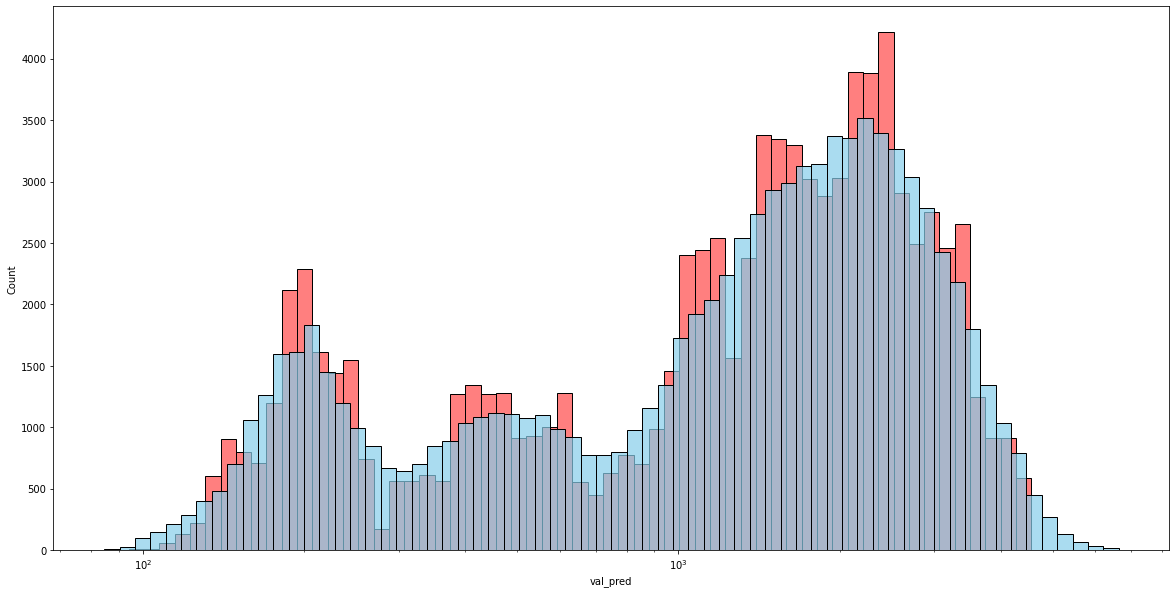

In [18]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

def nmae(y_true, y_pred):
    y_pred = np.expm1(y_pred)
    score = np.mean((np.abs(y_true-y_pred))/y_true)    
    return score

def xgb_nmae(preds, dtrain):
   preds = np.expm1(preds)
   labels = np.expm1(dtrain.get_label())
   return('nmae', np.mean(np.abs((labels - preds) / (labels))))


vars = ['hour',	'type', 'month',	'weekday', 'little_gas', '26~31','2~7']

X = train[vars]
y = train['amount']
log_y = np.log1p(y)

X_test = test[vars]


params = {
    'objective': 'reg:squarederror', 
    "learning_rate": 0.05,
    "metric": "mape",
    "tree_method": "gpu_hist",
    "seed":2021
}


n_fold = 24   
kf = KFold(n_splits=n_fold, random_state=None)


pred_val = np.zeros(int(len(X)/n_fold))
xgb_pred = np.zeros(len(test))

df_val_pred = pd.DataFrame()

for train_index, val_index in kf.split(X):

    train_features = X.loc[train_index]
    train_target = log_y.loc[train_index]
    
    val_features = X.loc[val_index]
    val_target = log_y.loc[val_index]
    
    d_training = xgb.DMatrix(train_features, label=train_target)
    d_val = xgb.DMatrix(val_features, label=val_target)
    wlist = [(d_training, 'train'), (d_val,'eval')]

    model = xgb.train(params, d_training, evals=wlist, num_boost_round=2000, verbose_eval=100, early_stopping_rounds=50, feval = xgb_nmae)
    

    val_pred = model.predict(xgb.DMatrix(val_features))
    df_val = pd.DataFrame({'val_pred':val_pred}, index = val_index) 
    df_val_pred = df_val_pred.append(df_val)
    
    test_pred = np.expm1(model.predict(xgb.DMatrix(X_test)))
    xgb_pred += test_pred / n_fold


sns.histplot(np.expm1(df_val_pred['val_pred']), color = 'red', alpha = 0.5,log_scale=True)
sns.histplot(df_chk['amount'], color = 'skyblue', alpha = 0.7,log_scale=True)

print('\nval_nmae', nmae(df_chk['amount'].values, df_val_pred['val_pred'].values))

In [19]:
submission['공급량'] = xgb_pred
display(submission[-50:].head())

,일자|시간|구분,공급량
15070,2019-03-29 23 H,287.382816
15071,2019-03-29 24 H,287.382816
15072,2019-03-30 01 H,255.568766
15073,2019-03-30 02 H,178.593643
15074,2019-03-30 03 H,152.513961


## Catboost

In [20]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [21]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import catboost
from catboost import CatBoostRegressor, Pool


def nmae(y_true, y_pred):
    y_pred = y_pred
    score = np.mean((np.abs(y_true-y_pred))/y_true)    
    return score


vars = ['hour',	'type', 'month',	'weekday', 'little_gas', '26~31','2~7']

X = train[vars]
y = train['amount']
log_y = np.log1p(y)

X_test = test[vars]


params = {
    'objective': 'MAPE',
    'n_estimators': 10000,
    'learning_rate': 0.05,
}


n_fold = 12
kf = KFold(n_splits=n_fold, random_state=None)

folds=[]
for train_idx, valid_idx in kf.split(X, y):
        folds.append((train_idx, valid_idx))

val_pred = np.zeros((X.shape[0]))
cat_pred = np.zeros((X_test.shape[0]))
cat_cols = ['hour',	'type', 'month',	'weekday', 'little_gas', '26~31','2~7']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], log_y[train_idx], log_y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostRegressor(task_type='GPU')
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
  
  val_pred[valid_idx] = np.expm1(model_cat.predict(X_valid))
  cat_pred += np.expm1(model_cat.predict(X_test)) / n_fold
  print(f'CV nmae: {nmae(np.expm1(y_valid), val_pred[valid_idx]):.6f}')
    
print(f'\n\n val_nmae: {nmae(y, val_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.100127
0:	learn: 0.8828045	test: 0.9375413	best: 0.9375413 (0)	total: 20.4ms	remaining: 20.3s
100:	learn: 0.1667097	test: 0.1781599	best: 0.1781046 (96)	total: 2.08s	remaining: 18.6s
200:	learn: 0.1644638	test: 0.1767958	best: 0.1766105 (190)	total: 3.99s	remaining: 15.9s
bestTest = 0.1766105253
bestIteration = 190
Shrink model to first 191 iterations.
CV nmae: 0.129649

----------------- Fold 1 -----------------

Learning rate set to 0.100127
0:	learn: 0.8928868	test: 0.8300507	best: 0.8300507 (0)	total: 21.5ms	remaining: 21.5s
100:	learn: 0.1659456	test: 0.1657952	best: 0.1653649 (87)	total: 2s	remaining: 17.8s
bestTest = 0.1653649272
bestIteration = 87
Shrink model to first 88 iterations.
CV nmae: 0.121552

----------------- Fold 2 -----------------

Learning rate set to 0.100127
0:	learn: 0.8859027	test: 0.9020429	best: 0.9020429 (0)	total: 18.6ms	remaining: 18.6s
100:	learn: 0.1673099	test: 0.1616632	best: 0.16139

In [22]:
submission['공급량'] = cat_pred
display(submission[-50:].head())

,일자|시간|구분,공급량
15070,2019-03-29 23 H,304.614201
15071,2019-03-29 24 H,288.541351
15072,2019-03-30 01 H,246.984815
15073,2019-03-30 02 H,182.431572
15074,2019-03-30 03 H,167.768744


## Minimum Ensemble
- 평가지표인 NMAE에서는 공급량이 적은 구간의 예측력이 중요함
- 예1) true 6000, pred 4000, nmae = abs(6000-4000)/6000 = 0.33
- 예2) true 500, pred 1500, nmae = abs(500-1500)/500 = 2
- 예측값의 최소추정이 점수에 유리하다고 판단하여 3개 모델 예측값 중 최소값을 최종 예측값으로 결정

In [23]:
submission['공급량'] = None
submission['lgb_pred'] = lgb_pred
submission['xgb_pred'] = xgb_pred
submission['cat_pred'] = cat_pred
submission['공급량'] = submission.min(axis=1) # 모델 예측값 중 최소값 적용
submission = submission[['일자|시간|구분', '공급량']]
submission.to_csv('3m_kfold_3ensemble.csv', index=False)
files.download('3m_kfold_3ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
submission['공급량'] = None
submission['lgb_pred'] = lgb_pred
submission['xgb_pred'] = xgb_pred
submission['cat_pred'] = cat_pred
submission['공급량'] = submission.min(axis=1)
submission

,일자|시간|구분,공급량,lgb_pred,xgb_pred,cat_pred
0,2019-01-01 01 A,2061.970535,2101.111564,2061.970535,2161.203070
1,2019-01-01 02 A,1792.151836,1809.501060,1794.805046,1792.151836
2,2019-01-01 03 A,1689.663193,1692.503973,1689.663193,1697.251391
3,2019-01-01 04 A,1727.195526,1727.287962,1727.195526,1737.477559
4,2019-01-01 05 A,1918.173037,1922.780823,1928.554031,1918.173037
...,...,...,...,...,...
15115,2019-03-31 20 H,331.726641,346.036616,348.172362,331.726641
15116,2019-03-31 21 H,327.655300,346.422274,348.185095,327.655300
15117,2019-03-31 22 H,318.780050,329.792687,323.940718,318.780050
15118,2019-03-31 23 H,283.641309,301.594178,283.641309,298.201697
